In [18]:
%matplotlib inline
import os

import numpy as np
import xarray as xr

import utils

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

import cartopy
import cartopy.crs as ccrs
import cmocean

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
xarray  0.15.1
cartopy 0.17.0
numpy   1.18.4
cmocean 2.0
Mike Levy 2020-05-08 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper16
Git hash   : 63f0387b1afc098e358ebd46e6a34d046fffc9c4


In [19]:
ds = xr.open_zarr('data/Ncycle.zarr').compute()
ds

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320)
Coordinates:
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
Dimensions without coordinates: nlat, nlon
Data variables:
    AREA       (nlat, nlon) float64 1.125e+09 1.125e+09 ... 7.431e+08 7.432e+08
    DENITRIF   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    diaz_Nfix  (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [20]:
dsp = utils.pop_add_cyclic(ds)
dsp

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
    TLONG      (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.57 -39.86
    AREA       (nlat, nlon) float64 8.592e+08 8.592e+08 ... 3.342e+08 3.341e+08
    DENITRIF   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    diaz_Nfix  (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan

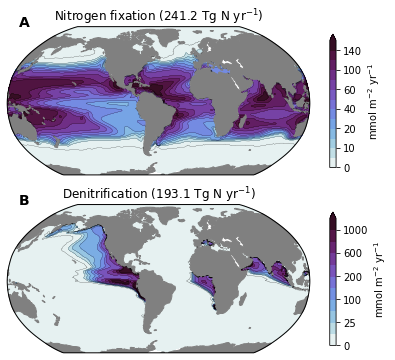

In [33]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=(1, 0.02,))

prj = ccrs.Robinson(central_longitude=305.0)

axs = []
maps = []

levels = dict(
    diaz_Nfix=[0., 5., 10., 15., 20., 30., 40., 50., 60., 80., 100., 120., 140., 200., ],
    DENITRIF=[0., 10., 25., 50., 100., 150., 200., 400., 600., 800., 1000., 1500., ]
)

cmap_field = cmocean.cm.dense

contour_spec = dict(
    diaz_Nfix=dict(
        levels=levels['diaz_Nfix'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['diaz_Nfix'], ncolors=cmap_field.N),
    ),
    DENITRIF=dict(
        levels=levels['DENITRIF'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['DENITRIF'], ncolors=cmap_field.N),
    ),
)

for i, var in enumerate(['diaz_Nfix', 'DENITRIF']):
    
    ax = plt.subplot(gs[i, 0], projection=prj)                         
    maps.append(ax)
    
    cf = ax.contourf(dsp.TLONG,
                     dsp.TLAT,
                     dsp[var],
                     **contour_spec[var],
                     transform=ccrs.PlateCarree())

    cl = ax.contour(dsp.TLONG,
                     dsp.TLAT,
                     dsp[var],
                     levels=levels[var],
                     colors='k', linewidths=0.2,
                     transform=ccrs.PlateCarree())
    
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )  
                             
    ax.set_title(dsp[var].attrs['title_str'])

    cb = plt.colorbar(cf, shrink=0.9)
    cb.set_label(dsp[var].units)
    
utils.label_plots(fig, maps, xoff=0.02, yoff=0)       
utils.savefig('Ncycle.pdf')